In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
# Set the Optuna logger to output only warnings or higher level messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

experiment = 'baseline'

import warnings
warnings.filterwarnings("ignore")

c:\Users\Adeniyi Babalola\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [3]:
# Constants
TARGET = 'Hardness'

In [4]:
# Selecting numerical variables from the train dataset, excluding 'id' and TARGET
num_var = train.drop(['id', TARGET], axis=1).select_dtypes(include=np.number).columns
print(num_var)

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')


In [5]:
# Combining train and test datasets for comparative analysis
# 'Source' column is added to label data from each dataset
df = pd.concat([
    train[num_var].assign(Source='Train'), 
    test[num_var].assign(Source='Test')
], axis=0, ignore_index=True)

#### No missing data in the both train and test datasets

In [6]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import median_absolute_error, make_scorer
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression, RidgeCV, PassiveAggressiveRegressor, SGDRegressor, Perceptron, LinearRegression, TheilSenRegressor, HuberRegressor, RANSACRegressor, Lasso, ElasticNet, Lars, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import svm

MLA = [
	# Trial Models
	MLPRegressor(random_state=5),
	TheilSenRegressor(random_state=5),
	HuberRegressor(),
	RANSACRegressor(random_state=5),
	Lasso(random_state=5),
	ElasticNet(random_state=5),
	Lars(random_state=5),
	LassoLars(random_state=5),
	OrthogonalMatchingPursuit(),
	BayesianRidge(),
	ARDRegression(),

	# GLM
	LinearRegression(),
	PassiveAggressiveRegressor(random_state=5),
	RidgeCV(),
	# SGDRegressor(),

	# SVM
	svm.SVR(),
	svm.NuSVR(),

	# Trees    
	DecisionTreeRegressor(random_state=5),
	ExtraTreeRegressor(random_state=5),

	XGBRegressor(random_state=5),
	LGBMRegressor(n_jobs=-1, random_state=5),
	CatBoostRegressor(random_state=5, verbose=False, early_stopping_rounds=100),
	
	# KNeighbors
	KNeighborsRegressor(),
	KNeighborsRegressor(n_neighbors=2),
	KNeighborsRegressor(n_neighbors=4),
	KNeighborsRegressor(n_neighbors=8),
	KNeighborsRegressor(n_neighbors=16),
	KNeighborsRegressor(n_neighbors=32),
	KNeighborsRegressor(n_neighbors=64),
	KNeighborsRegressor(n_neighbors=128),
	KNeighborsRegressor(n_neighbors=256),
	KNeighborsRegressor(n_neighbors=512),
	KNeighborsRegressor(n_neighbors=1024),

	# Ensemble Methods
	AdaBoostRegressor(random_state=5),
	BaggingRegressor(random_state=5),
	ExtraTreesRegressor(random_state=5),
	GradientBoostingRegressor(random_state=5),
	HistGradientBoostingRegressor(random_state=5),
	RandomForestRegressor(random_state=5),
    ]


# split dataset in cross-validation with splitter class
# cv_split could KFold, StratifiedKFold or RepeatedKFold depending on the problem
cv_split = KFold(n_splits=10, shuffle=True, random_state=5)
cv_split_trial = KFold(n_splits=2, shuffle=True, random_state=5) # For quick trials

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare MLA predictions
MLA_predict = {}

# index through MLA and save performance to table
row_index = 0
scoring = median_abs_error_scorer = make_scorer(median_absolute_error, greater_is_better=False)

for alg in MLA:

	# set name and parameters
	MLA_name = alg.__class__.__name__

	# Add suffix if name already exists
	suffix = 1
	original_MLA_name = MLA_name
	while MLA_compare['MLA Name'].str.contains(MLA_name).any():
		MLA_name = f"{original_MLA_name}_{suffix}"
		suffix += 1
		
	MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
	MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

	"""score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate"""

	cv_results = cross_validate(alg, train[num_var], train[TARGET], cv=cv_split, scoring=scoring, return_train_score=True)

	# Calculate mean time in seconds
	mean_fit_time = cv_results['fit_time'].mean()

	# Convert mean time to minutes and seconds
	minutes = int(mean_fit_time // 60)
	seconds = mean_fit_time % 60

	# Format the time and assign it
	MLA_compare.loc[row_index, 'MLA Time'] = f"{minutes} min {seconds:.2f} sec"
	MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean() * -1
	MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean() * -1
	#if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
	MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!


	# # #save MLA predictions - see section 6 for usage
	# alg.fit(data1[data1_x_bin], data1[Target])
	# MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
	print(f'Done with {MLA_name}')
	row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = True, inplace = True)
MLA_compare.to_csv(f'{experiment}_results.csv', index=False)
MLA_compare

Done with MLPRegressor
Done with TheilSenRegressor
Done with HuberRegressor
Done with RANSACRegressor
Done with Lasso
Done with ElasticNet
Done with Lars
Done with LassoLars
Done with OrthogonalMatchingPursuit
Done with BayesianRidge
Done with ARDRegression
Done with LinearRegression
Done with PassiveAggressiveRegressor
Done with RidgeCV
Done with SVR
Done with NuSVR
Done with DecisionTreeRegressor
Done with ExtraTreeRegressor
Done with XGBRegressor
Done with LGBMRegressor
Done with CatBoostRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor_1
Done with KNeighborsRegressor_2
Done with KNeighborsRegressor_3
Done with KNeighborsRegressor_4
Done with KNeighborsRegressor_5
Done with KNeighborsRegressor_6
Done with KNeighborsRegressor_7
Done with KNeighborsRegressor_8
Done with KNeighborsRegressor_9
Done with KNeighborsRegressor_10
Done with AdaBoostRegressor
Done with BaggingRegressor
Done with ExtraTreesRegressor
Done with GradientBoostingRegressor
Done with HistGradient

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
34,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",-0.0,0.6454,0.070359,0 min 3.61 sec
19,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.538757,0.646299,0.10126,0 min 0.24 sec
37,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.239525,0.6505,0.078558,0 min 8.87 sec
36,HistGradientBoostingRegressor,"{'categorical_features': None, 'early_stopping...",0.539193,0.654591,0.107056,0 min 1.32 sec
20,CatBoostRegressor,"{'loss_function': 'RMSE', 'verbose': False, 'r...",0.502311,0.656291,0.099706,0 min 5.46 sec
18,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",0.350712,0.662962,0.083955,0 min 0.89 sec
33,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",0.249,0.683,0.110675,0 min 0.86 sec
35,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.675702,0.700971,0.113716,0 min 2.08 sec
24,KNeighborsRegressor_3,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.65,0.74375,0.095238,0 min 0.02 sec
21,KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.61,0.753,0.100444,0 min 0.02 sec


Text(0, 0.5, 'Algorithm')

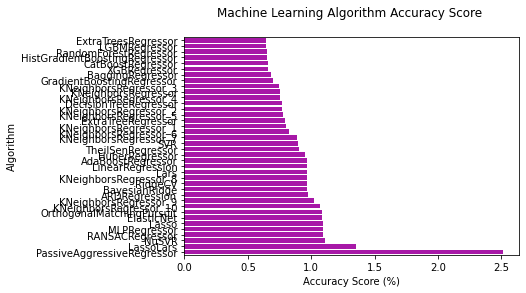

In [7]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [8]:
def objective(trial, y_test, predictions):
    weighted_predictions = np.zeros_like(predictions[0])
    for i in range(len(MLA)):
        # Assign a weight to each prediction
        weight = trial.suggest_float(f'w{i}', 0, 1)
        weighted_predictions += weight * predictions[i]
    weighted_predictions /= np.sum(weighted_predictions)  # Normalize weights

    # Calculate metric on your validation set
    mae = median_absolute_error(y_test, weighted_predictions)
    return mae

In [9]:
def weighted_avg_objective(trial, y_true, model_predictions):
    # The model_predictions is a list of prediction arrays from the three models
    weighted_predictions = np.zeros_like(model_predictions[0])
    total_weight = 0

    for i in range(len(model_predictions)):
        # Define the weight for each model
        weight = trial.suggest_float(f'w{i}', 0, 1)
        total_weight += weight
        weighted_predictions += weight * model_predictions[i]

    # Normalize the predictions by the total weight
    if total_weight > 0:
        weighted_predictions /= total_weight

    # Calculate the median absolute error
    return median_absolute_error(y_true, weighted_predictions)

In [10]:
# Hill Climbing inspired by code from Kaggle
def hill_climbing(x, y):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = median_absolute_error(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df
    x = x[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [median_absolute_error(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = median_absolute_error(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = median_absolute_error(y, potential_ensemble)
                if cv_score < potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred = current_best_ensemble
    
    return hill_ens_pred

In [11]:
avg_predictions_scores = []
optuna_weights_scores = []
hill_climb_scores = []
stacked_scores = []
optuna_weights_scores_stack = []

for i, (train_index, test_index) in enumerate(cv_split.split(train[num_var], train[TARGET])):
    X_train, X_test = train[num_var].iloc[train_index], train[num_var].iloc[test_index]
    y_train, y_test = train[TARGET].iloc[train_index], train[TARGET].iloc[test_index]

    print(f'Fold {i+1}')
    
    MLA_cv_train_preds = []
    MLA_cv_preds = []
    MLA_cv_preds_dict = {}
    
    for alg in MLA:
        MLA_name = alg.__class__.__name__

        # Add suffix if name already exists
        suffix = 1
        original_MLA_name = MLA_name
        if MLA_name in MLA_cv_preds:
        # while MLA_cv_preds.str.contains(MLA_name).any():
            MLA_name = f"{original_MLA_name}_{suffix}"
            suffix += 1
            
        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name

        predictor = alg.fit(X_train, y_train)
        pred_train_result = predictor.predict(X_train)
        pred_result = predictor.predict(X_test)

        MLA_cv_train_preds.append(pred_train_result)
        MLA_cv_preds.append(pred_result)
        MLA_cv_preds_dict[MLA_name] = pred_result

    #################
    ### Averaging ###
    #################
    avg_prediction = np.mean(MLA_cv_preds, axis=0)
    avg_prediction_score = median_absolute_error(y_test, avg_prediction)
    avg_predictions_scores.append(avg_prediction_score)
    print(f'The Fold {i+1} average prediction is {avg_prediction_score}')

    ##############
    ### Optuna ###
    ##############
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, y_test, MLA_cv_preds), n_trials=200)

    # Use the best weights
    best_weights = [study.best_params[f'w{i}'] for i in range(len(MLA))]
    weighted_avg_predictions = np.average(MLA_cv_preds, axis=0, weights=best_weights)
    weighted_avg_predictions_score = median_absolute_error(y_test, weighted_avg_predictions)
    optuna_weights_scores.append(weighted_avg_predictions_score)
    print(f'The Fold {i+1} Optuna weights is {weighted_avg_predictions_score}')

    ##################
    ### Hill Climb ###
    ##################
    hill_climb_pred = hill_climbing(pd.DataFrame(MLA_cv_preds_dict), y_test)
    hill_climb_score = median_absolute_error(y_test, hill_climb_pred)
    hill_climb_scores.append(hill_climb_score)
    print(f'The Fold {i+1} Hill Climb is {hill_climb_score}')

    ###############################
    ### Simple 2-Level Stacking ###
    ###############################
    stacked_features = np.column_stack(MLA_cv_train_preds)
    stacked_test = np.column_stack(MLA_cv_preds)

    meta_model = LGBMRegressor(n_jobs=-1, random_state=5)
    meta_model.fit(stacked_features, y_train)
    stacked_prediction = meta_model.predict(stacked_test)
    stacked_score = median_absolute_error(y_test, stacked_prediction)
    stacked_scores.append(stacked_score)
    print(f'The Fold {i+1} 2-Level Stacked Score is {stacked_score}')

    ###############################################################
    ### 2-Level Multi-Model Stack with 3-Level Weighted Average ###
    ###############################################################
    # LGBM
    meta_model_lgbm = LGBMRegressor(n_jobs=-1, random_state=5)
    meta_model_lgbm.fit(stacked_features, y_train)
    stacked_prediction_lgbm = meta_model_lgbm.predict(stacked_test)
    stacked_score_lgbm = median_absolute_error(y_test, stacked_prediction_lgbm)

    # XGBRegressor(seed=5)
    meta_model_xgb = XGBRegressor(seed=5)
    meta_model_xgb.fit(stacked_features, y_train)
    stacked_prediction_xgb = meta_model_xgb.predict(stacked_test)
    stacked_score_xgb = median_absolute_error(y_test, stacked_prediction_xgb)

    # CatBoost
    meta_model_cat = CatBoostRegressor(random_state=5, verbose=False, early_stopping_rounds=100)
    meta_model_cat.fit(stacked_features, y_train)
    stacked_prediction_cat = meta_model_cat.predict(stacked_test)
    stacked_score_cat = median_absolute_error(y_test, stacked_prediction_cat)
    
    # Stack the predictions from your three models
    second_level_predictions = [
        stacked_prediction_lgbm,
        stacked_prediction_xgb,
        stacked_prediction_cat
    ]

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: weighted_avg_objective(trial, y_test, second_level_predictions), n_trials=200)

    best_weights = [study.best_params[f'w{i}'] for i in range(len(second_level_predictions))]
    weighted_avg_prediction = np.average(second_level_predictions, axis=0, weights=best_weights)
    weighted_avg_score = median_absolute_error(y_test, weighted_avg_prediction)
    print(f"The Fold {i+1} 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: {weighted_avg_score}")
    optuna_weights_scores_stack.append(weighted_avg_score)
    print()

print()
print(f'The average prediction CV score is ==> {np.mean(avg_predictions_scores)}')
print(f'The Optuna weights CV score is ==> {np.mean(optuna_weights_scores)}')
print(f'The Hill Climbing CV score is ==> {np.mean(hill_climb_scores)}')
print(f'The 2-Level Stacking CV score is ==> {np.mean(stacked_scores)}')
print(f'The 2-Level Multi-Model Stack with 3-Level Weighted Average CV score is ==> {np.mean(optuna_weights_scores_stack)}')

Fold 1
The Fold 1 average prediction is 0.848196287144015
The Fold 1 Optuna weights is 0.8049733095398124
The Fold 1 Hill Climb is 0.590140689479492
The Fold 1 2-Level Stacked Score is 0.7998279262085437
The Fold 1 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: 0.6736792048758629

Fold 2
The Fold 2 average prediction is 0.8826842360498657
The Fold 2 Optuna weights is 0.9289560050356576
The Fold 2 Hill Climb is 0.5972934237325407
The Fold 2 2-Level Stacked Score is 0.7998569501416068
The Fold 2 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: 0.7420734381394585

Fold 3
The Fold 3 average prediction is 0.9188484992368977
The Fold 3 Optuna weights is 0.8440470314463333
The Fold 3 Hill Climb is 0.6699304985949741
The Fold 3 2-Level Stacked Score is 0.8000214252290476
The Fold 3 2-Level Multi-Model Stack with 3-Level Weighted Average Prediction Score: 0.7158674142231716

Fold 4
The Fold 4 average prediction is 0.8279771394870998
The Fold 4